# RL and Advanced DL: Домашнее задание 3

In [ ]:
import os
from pathlib import Path

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Часть первая: перенос стиля при помощи pix2pix

В этом задании мы будем реализовывать перенос стиля на спаренных данных (paired data). Из стандартных датасетов я выбрал самый маленький -- давайте реализуем перенос стиля из масок сегментации в “настоящие фотографии” для конкретного случая фасадов домов:
![image-2.png](attachment:image-2.png)

Датасет можно скачать [здесь](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz) (и во многих других местах, должно быть ~29 мегабайт).

В первой части подразумевается реализация pix2pix архитектуры, т.е. генератора и дискриминатора, которые получают на вход условие в виде изображения исходного стиля (подробнее см. лекцию и собственно [Isola et al., 2016](https://arxiv.org/pdf/1611.07004.pdf):
![image-3.png](attachment:image-3.png)


In [ ]:
!wget -nc http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz

File ‘facades.tar.gz’ already there; not retrieving.



In [ ]:
!tar -xf facades.tar.gz

In [ ]:
class PixToPixDataset(Dataset):
    def __init__(self, path_dir):
        super().__init__()
        self.images = [os.path.join(path_dir, path) for path in os.listdir(path_dir)]
        self.transforms = torchvision.transforms.ToTensor()

    def __len__(self):
        return len(self.images)

    @staticmethod
    def _split_image(img):
        image_array = np.array(img)
        split_line = img.width // 2
        output_img = image_array[:, split_line:]
        input_img = image_array[:, :split_line]
        
        return output_img, input_img
        
    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path)
        output_img, input_img = self._split_image(img)
        output_img = self.transforms(output_img)
        input_img = self.transforms(input_img)
        
        return output_img, input_img

[U-Net: Semantic segmentation with PyTorch](https://github.com/milesial/Pytorch-UNet/tree/e1a69e7c6ce18edd47271b01e4aabc03b436753d#u-net-semantic-segmentation-with-pytorch)

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        factor = 2

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024 // factor)
        
        self.up1 = Up(1024, 512 // factor)
        self.up2 = Up(512, 256 // factor)
        self.up3 = Up(256, 128 // factor)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits    

In [ ]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels, batch_norm=True):
        super().__init__()
        layers = [nn.Conv2d(in_channels, out_channels, 3, 2, 1, bias=False)]
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        self.conv_block = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv_block(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            ConvBlock(2 * in_channels, 16, batch_norm=False),
            ConvBlock(16, 64),
            ConvBlock(64, 256),
            ConvBlock(256, 512),
            nn.Conv2d(512, 1, 2, 1, bias=False),
            nn.AvgPool2d((1, 1)),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.discriminator(x)

In [ ]:
BATCH_SIZE = 16
train_dataset = PixToPixDataset('facades/train/')
test_dataset = PixToPixDataset('facades/test/')

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
revert_image = torchvision.transforms.ToPILImage()

def show_eval_image(g_model, figsize=(16, 9), img_id=8):
        in_i, out_i = test_dataset[img_id]
        fig, ax = plt.subplots(1, 3)
        fig.set_figheight(figsize[0])
        fig.set_figwidth(figsize[1])
        
        ax[0].imshow(revert_image(in_i))
        ax[0].axis('off')
        ax[1].imshow(revert_image(out_i))
        ax[1].axis('off')
        ax[2].imshow(revert_image(g_model(in_i.unsqueeze(0).to(DEVICE)).squeeze()))
        ax[2].axis('off')
        plt.show()

        
def train(g_model, g_opt, d_model, d_opt, alpha=10, n_epoch=10, device=DEVICE):
    for i, epoch in enumerate(range(n_epoch)):
            epoch_g_losses = []
            epoch_d_losses = []

            for input_tensor, output_tensor in tqdm(train_dataloader, total=len(train_dataloader)):
                input_tensor = input_tensor.to(device)
                output_tensor = output_tensor.to(device)

                # generator
                g_opt.zero_grad()
                
                g_model.train()
                d_model.eval()
                x_gen = g_model(input_tensor)
                pred_fake = d_model(torch.cat([input_tensor, x_gen], dim=1))
                pred_true = d_model(torch.cat([input_tensor, output_tensor], dim=1))
                g_loss = alpha * F.l1_loss(x_gen.cpu(), output_tensor.cpu()) - torch.log(pred_fake.cpu()).mean() # alpha * l1 + bce
                g_loss.backward()
                g_opt.step()

                # discriminator
                d_opt.zero_grad()
                
                d_model.train()
                pred_fake = d_model(torch.cat([x_gen.detach(), output_tensor], dim=1))
                d_loss = -torch.log(1 - pred_fake.cpu()).mean() - torch.log(pred_true.cpu()).mean() # bce_fake + bce_true
                d_loss.backward()
                d_opt.step()

                epoch_g_losses.append(g_loss.item())
                epoch_d_losses.append(d_loss.item())

            show_eval_image(g_model)
            print(f"Epoch {i + 1}/{n_epoch}, train losses: gen {np.mean(epoch_g_losses):.4f}/ disc {np.mean(epoch_d_losses):.4f}")    

In [ ]:
out_dim = 3

generator = UNet(n_channels=3, n_classes=out_dim).to(DEVICE)
discriminator = Discriminator(out_dim).to(DEVICE)

opt_g = torch.optim.Adam(generator.parameters(), lr=7e-4)
opt_d = torch.optim.Adam(discriminator.parameters(), lr=1e-3)

100%|██████████| 25/25 [00:55<00:00,  2.22s/it]


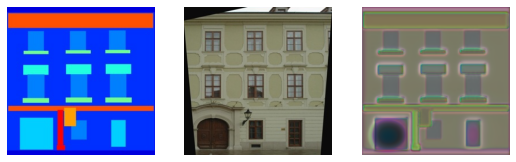

Epoch 1/10, train losses: gen 1.0000/ disc 0.3497


100%|██████████| 25/25 [00:54<00:00,  2.20s/it]


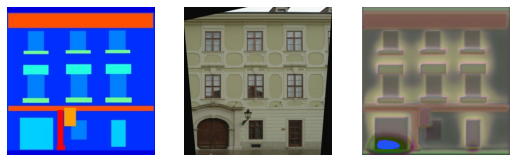

Epoch 2/10, train losses: gen 0.5604/ disc 0.0106


100%|██████████| 25/25 [00:54<00:00,  2.19s/it]


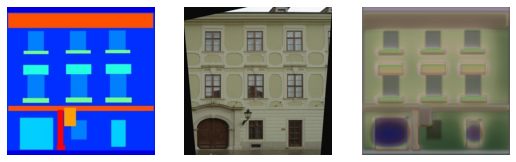

Epoch 3/10, train losses: gen 0.5463/ disc 0.0028


100%|██████████| 25/25 [00:54<00:00,  2.19s/it]


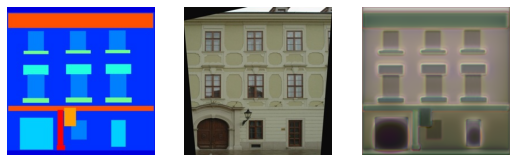

Epoch 4/10, train losses: gen 0.5328/ disc 0.0012


100%|██████████| 25/25 [00:54<00:00,  2.19s/it]


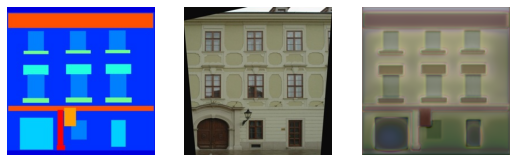

Epoch 5/10, train losses: gen 0.5242/ disc 0.0010


100%|██████████| 25/25 [00:54<00:00,  2.19s/it]


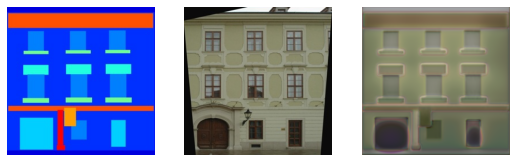

Epoch 6/10, train losses: gen 0.5195/ disc 0.0007


100%|██████████| 25/25 [00:54<00:00,  2.19s/it]


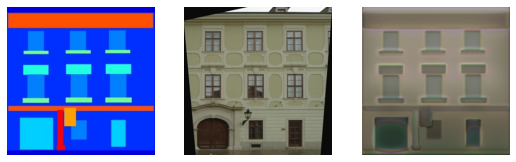

Epoch 7/10, train losses: gen 0.5187/ disc 0.0007


100%|██████████| 25/25 [00:54<00:00,  2.19s/it]


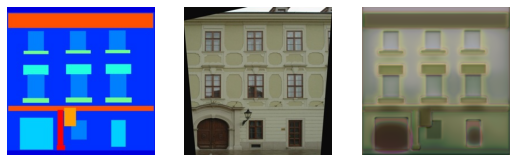

Epoch 8/10, train losses: gen 0.5178/ disc 0.0006


100%|██████████| 25/25 [00:54<00:00,  2.19s/it]


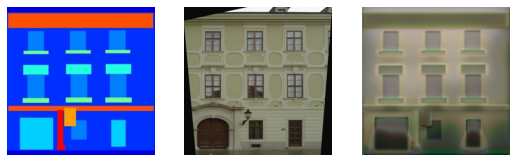

Epoch 9/10, train losses: gen 0.5184/ disc 0.0009


100%|██████████| 25/25 [00:54<00:00,  2.19s/it]


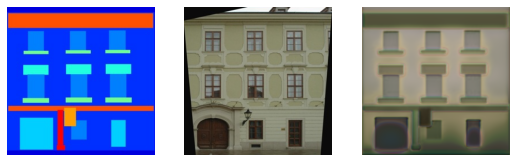

Epoch 10/10, train losses: gen 0.5115/ disc 0.0005


In [ ]:
train(generator, opt_g, discriminator, opt_d, alpha=3)

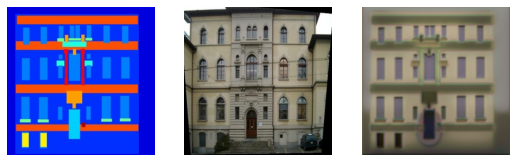

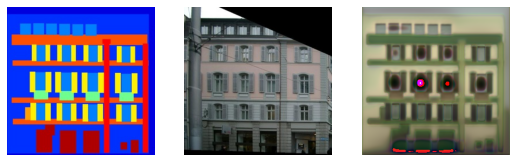

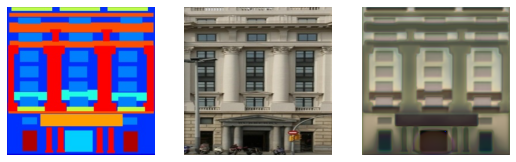

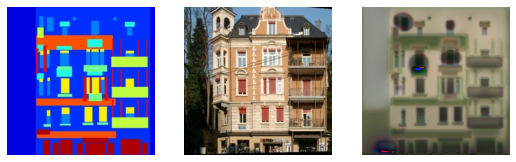

In [ ]:
show_eval_image(generator, figsize=(16, 9), img_id=11)
show_eval_image(generator, figsize=(16, 9), img_id=23)
show_eval_image(generator, figsize=(16, 9), img_id=30)
show_eval_image(generator, figsize=(16, 9), img_id=39)

## Часть вторая: добавим циклы

Вторая часть -- реализация CycleGAN. Предлагается на том же датасете реализовать базовую конструкцию CycleGAN для unpaired style transfer, то есть переноса стилей, каждый из которых задан неразмеченным датасетом (подробнее см. лекцию и собственно [Zhu et al., 2017](https://arxiv.org/pdf/1703.10593.pdf):

![image.png](attachment:image.png)

В качестве опционального задания за немного дополнительных баллов здесь предлагаю найти дополнительные данные такого рода (фасады и их карты сегментации) и улучшить качество переноса стиля за счёт обучения на датасете побольше. Данные, скорее всего, будут unpaired, поэтому эта часть скорее релевантна CycleGAN.
